# Contents

* [Libraries](#Libraries)
* [Data](#Data)
* [Modeling](#Modeling)
    - [Linear Regression](#Linear-Regression)
    - [Lasso](#Lasso)
    - [Ridge](#Ridge)
* [Submission](#Submission)

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Data 

In [2]:
# training and test data
df_train = pd.read_csv('../datasets/clean_train.csv')
df_test = pd.read_csv('../datasets/clean_test.csv')

df_train.drop(columns = ['Unnamed: 0', 'exterior_1st_ImStucc', 'heating_OthW', 
                         'exterior_1st_Stone', 'exterior_1st_CBlock', 'electrical_Mix', 
                         'heating_Wall', 'ms_zoning_A (agr)'], 
              inplace = True)
df_test.drop(columns = ['Unnamed: 0'], inplace = True)

# Modeling 

## Model Setup

In [3]:
features = df_train.select_dtypes([np.number]).drop(columns = ['saleprice']).columns

X = df_train[features]
y = df_train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 34)

## Check for Multicolinearity

In [4]:
# source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def calc_vif(X):
    vif_data = pd.DataFrame()
    vif_data['features'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return(vif_data.sort_values(by = 'VIF'))

calc_vif(X_test)

,features,VIF
46,3ssn_porch,1.135959
50,mo_sold,1.297269
47,screen_porch,1.390511
55,paved_drive_P,1.467339
3,lot_frontage,1.556284
...,...,...
85,exterior_1st_AsphShn,NaN
86,exterior_1st_BrkComm,NaN
101,foundation_Wood,NaN
111,sale_type_Con,NaN


## Linear Regression

In [5]:
lr = LinearRegression(n_jobs = -1)

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_residuals = y_test - lr_pred

print('r2 train score:', lr.score(X_train, y_train))
print('r2 test score:', lr.score(X_test, y_test))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test).mean())
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lr_pred)))

r2 train score: 0.8714222320182234
r2 test score: 0.8775926141352163
Cross Val Score: 0.8598415644554702
RMSE: 26516.22368215707


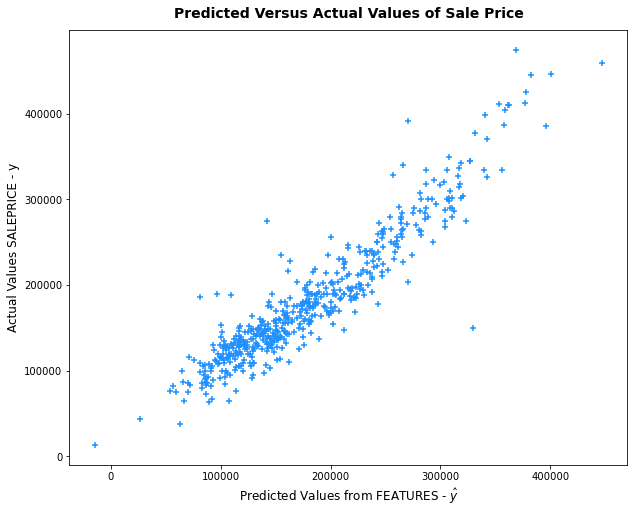

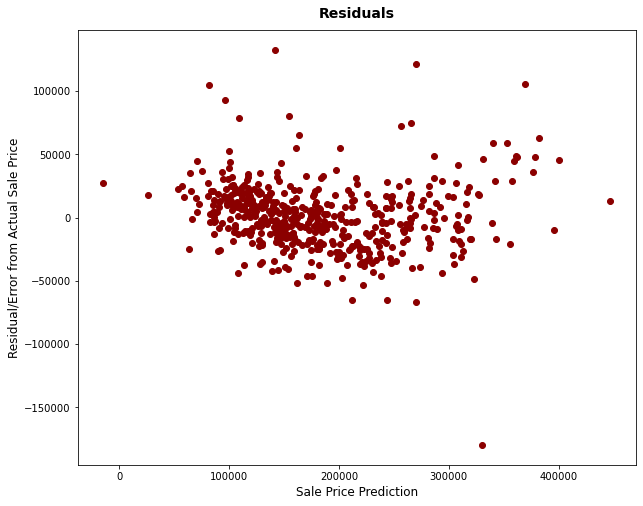

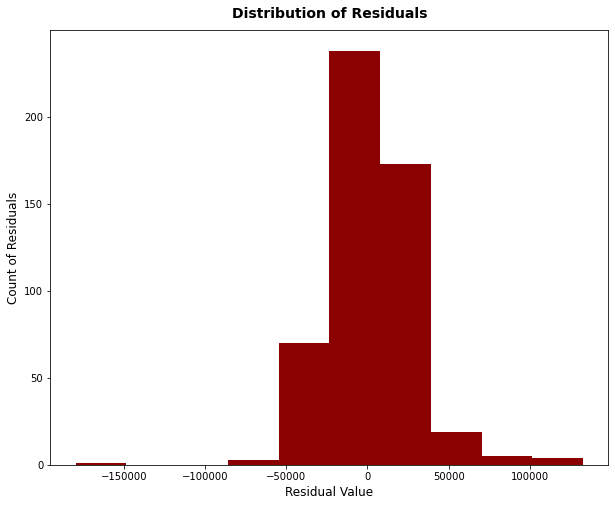

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(lr_pred, y_test, s = 30, c = 'dodgerblue', marker = '+')
plt.xlabel("Predicted Values from FEATURES - $\hat{y}$", fontsize = 12)
plt.ylabel("Actual Values SALEPRICE - y", fontsize = 12)
plt.title('Predicted Versus Actual Values of Sale Price', fontsize = 14, fontweight = 'bold', pad = 12)

plt.figure(figsize=(10,8))
plt.scatter(lr_pred, lr_residuals, color = 'darkred')
plt.xlabel("Sale Price Prediction", fontsize = 12)
plt.ylabel("Residual/Error from Actual Sale Price", fontsize = 12)
plt.title('Residuals', fontsize = 14, fontweight = 'bold', pad = 12)

plt.figure(figsize=(10,8))
plt.hist(lr_residuals, color = 'darkred')
plt.xlabel("Residual Value", fontsize = 12)
plt.ylabel("Count of Residuals", fontsize = 12)
plt.title('Distribution of Residuals', fontsize = 14, fontweight = 'bold', pad = 12);

## LassoCV

In [7]:
lasso = LassoCV()
ss = StandardScaler()

ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

X_kaggle = df_test[features]
X_kaggle_sc = ss.transform(X_kaggle)

lasso.fit(X_train_sc, y_train)
lasso_pred = lasso.predict(X_test_sc)
lasso_residuals = y_test - lasso_pred
lasso_df = list(zip(X_test.columns, lasso.coef_))

print('r2 test score:', lasso.score(X_test_sc, y_test))
print('r2 training score:', lasso.score(X_train_sc, y_train))
print('Cross Val Score:', cross_val_score(lasso, X_test_sc, y_test).mean())
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_pred)))

r2 test score: 0.8836560064523115
r2 training score: 0.8636603846584878
Cross Val Score: 0.8799977750623004
RMSE: 25851.148701164562


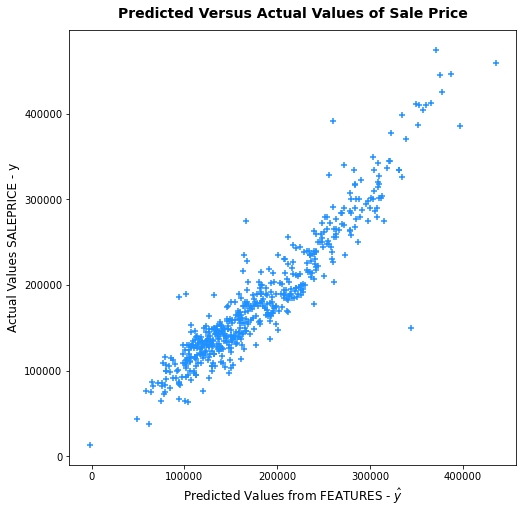

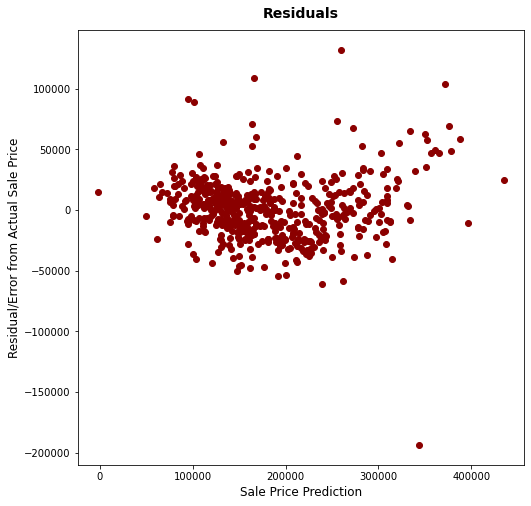

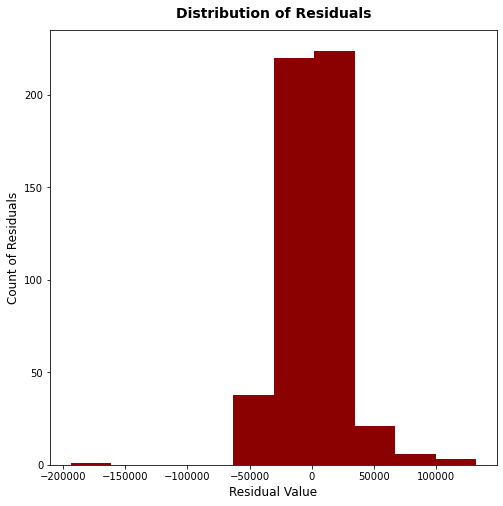

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(lasso_pred, y_test, s = 30, c = 'dodgerblue', marker = '+')
plt.xlabel("Predicted Values from FEATURES - $\hat{y}$", fontsize = 12)
plt.ylabel("Actual Values SALEPRICE - y", fontsize = 12)
plt.title('Predicted Versus Actual Values of Sale Price', fontsize = 14, fontweight = 'bold', pad = 12)

plt.figure(figsize=(8,8))
plt.scatter(lasso_pred, lasso_residuals, color = 'darkred')
plt.xlabel("Sale Price Prediction", fontsize = 12)
plt.ylabel("Residual/Error from Actual Sale Price", fontsize = 12)
plt.title('Residuals', fontsize = 14, fontweight = 'bold', pad = 12);

plt.figure(figsize=(8,8))
plt.hist(lasso_residuals, bins = 10, color = 'darkred')
plt.xlabel("Residual Value", fontsize = 12)
plt.ylabel("Count of Residuals", fontsize = 12)
plt.title('Distribution of Residuals', fontsize = 14, fontweight = 'bold', pad = 12);

## RidgeCV

In [9]:
ridge = RidgeCV()

ridge.fit(X_train_sc, y_train)
ridge_pred = ridge.predict(X_test_sc)
ridge_residuals = y_test - ridge_pred

# score, slope, intercept, and metrics
print('r2 training score:', ridge.score(X_train_sc, y_train))
print('r2 test score:', ridge.score(X_test_sc, y_test))
print('cross_val_score:', cross_val_score(ridge, X_test_sc, y_test).mean())
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test, ridge_pred)))

r2 training score: 0.871291926908342
r2 test score: 0.8777418012083316
cross_val_score: 0.8665268130021031
rmse: 26500.06009921775


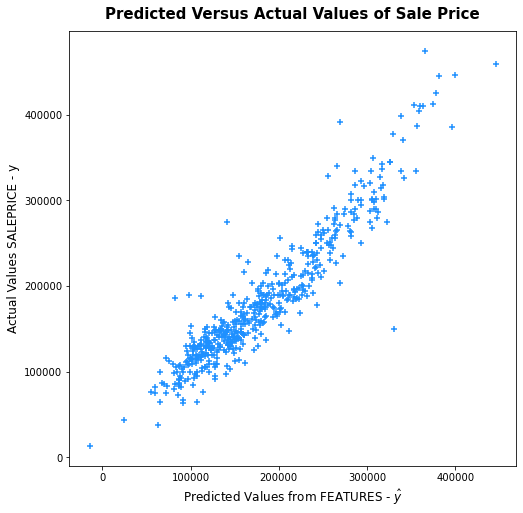

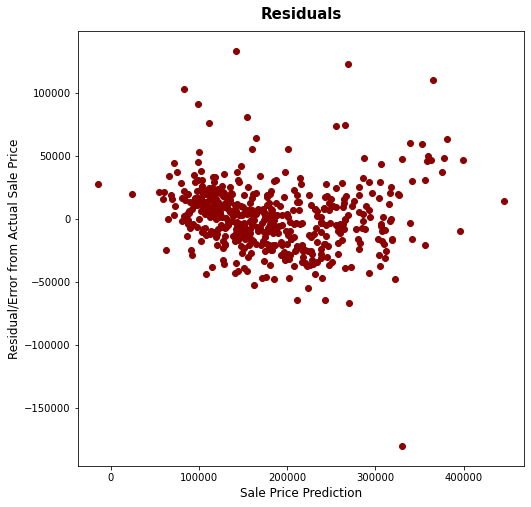

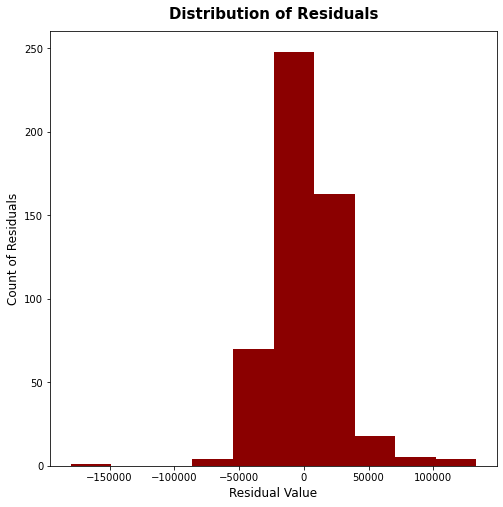

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(ridge_pred, y_test, s = 30, c = 'dodgerblue', marker = '+')
plt.xlabel("Predicted Values from FEATURES - $\hat{y}$", fontsize = 12)
plt.ylabel("Actual Values SALEPRICE - y", fontsize = 12)
plt.title('Predicted Versus Actual Values of Sale Price', fontsize = 15, fontweight = 'bold', pad = 12)

plt.figure(figsize=(8,8))
plt.scatter(ridge_pred, ridge_residuals, color = 'darkred')
plt.xlabel("Sale Price Prediction", fontsize = 12)
plt.ylabel("Residual/Error from Actual Sale Price", fontsize = 12)
plt.title('Residuals', fontsize = 15, fontweight = 'bold', pad = 12)

plt.figure(figsize=(8,8))
plt.hist(ridge_residuals, bins = 10, color = 'darkred')
plt.xlabel("Residual Value", fontsize = 12)
plt.ylabel("Count of Residuals", fontsize = 12)
plt.title('Distribution of Residuals', fontsize = 15, fontweight = 'bold', pad = 12);

# Submission

In [11]:
kag_submission = df_test
kag_pred = lr.predict(df_test[features])
kag_submission['saleprice'] = kag_pred
kag_submission[['id', 'saleprice']]
kaggle = kag_submission[['id', 'saleprice']]
kaggle.to_csv('../datasets/lr_submission.csv', index = False)

In [12]:
kag_submission = df_test
kag_pred = lasso.predict(df_test[features])
kag_submission['saleprice'] = kag_pred
kag_submission[['id', 'saleprice']]
kaggle = kag_submission[['id', 'saleprice']]
kaggle.to_csv('../datasets/lasso_submission.csv', index = False)

In [13]:
kag_submission = df_test
kag_pred = ridge.predict(df_test[features])
kag_submission['saleprice'] = kag_pred
kag_submission[['id', 'saleprice']]
kaggle = kag_submission[['id', 'saleprice']]
kaggle.to_csv('../datasets/ridge_submission.csv', index = False)